# Goals 
1. the core task we're interested in is identifying those customers most likely to subscribe to a term deposit

 

2. actionable patterns in data

 

3. does frequent contact have an adverse effect

 

4. seperate models for historic economic indicators

 

5. the model should be saved to a file

 

6. run the model on a different set of data and make target predictions

In [81]:

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import os
os.environ["COLUMNS"] = "74" # output width, in characters 
np.set_printoptions(linewidth=74) 
pd.set_option("display.width", 74)

Use pandas to read in the datasets as a dataframe.

In [82]:
campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')

Questions we should be asking 
Are social status and stbility relevant?
Are date and time conditions relevant?
Are banking profiling indicatiors relevant?
Are financial assets relevant?
Is residence district relevant?
Can age be related to products with longer term periods?

Checking the data and investigating the column types.

In [83]:
campaign.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [84]:
campaign.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000
mean,40.025493,2.564407,962.221803,0.173730,0.081526,93.576551,-40.494829,3.621945,5167.010650
std,10.435288,2.764084,187.531477,0.496159,1.572287,0.579339,4.628895,1.734496,72.294476
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [85]:
print(campaign.shape) # prints data shape - returns the row and column count of a dataset
print(campaign.columns) # print columns
campaign.head()

(37069, 20)
Index(['age', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [86]:
#Checking out the categories and their respective counts in each feature - running it through a for loop 
for col in campaign.select_dtypes(include='object').columns: 
    print(col, "column")
    print("Number of unique:", campaign[col].nunique())
    print(campaign[col].value_counts(), '\n')

job column
Number of unique: 12
job
admin.           9400
blue-collar      8329
technician       6066
services         3548
management       2648
retired          1534
entrepreneur     1308
self-employed    1274
housemaid         962
unemployed        913
student           793
unknown           294
Name: count, dtype: int64 

marital column
Number of unique: 4
marital
married     22456
single      10410
divorced     4134
unknown        69
Name: count, dtype: int64 

education column
Number of unique: 8
education
university.degree      10949
high.school             8554
basic.9y                5427
professional.course     4742
basic.4y                3764
basic.6y                2082
unknown                 1535
illiterate                16
Name: count, dtype: int64 

default column
Number of unique: 3
default
no         29341
unknown     7725
yes            3
Name: count, dtype: int64 

housing column
Number of unique: 3
housing
yes        19474
no         16701
unknown      894
Name: 

In [87]:
# To check if we have any null values using below code for better clarification.
campaign.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [88]:
# Finding the unique values of y
campaign['y'].unique()

array(['no', 'yes'], dtype=object)

In [89]:
# values for 'y' is yes and no. count all y 
# how many people(client) have subscribed to a term deposit?  
campaign['y'].value_counts()

y
no     32861
yes     4208
Name: count, dtype: int64

In [90]:
# 
campaign["y"].value_counts()/len(campaign.y)

y
no     0.886482
yes    0.113518
Name: count, dtype: float64

The distribution of the target variables(y) 32861 - no and 4208- yes
which is broken down to 88 % saying no and 11 % saying yes

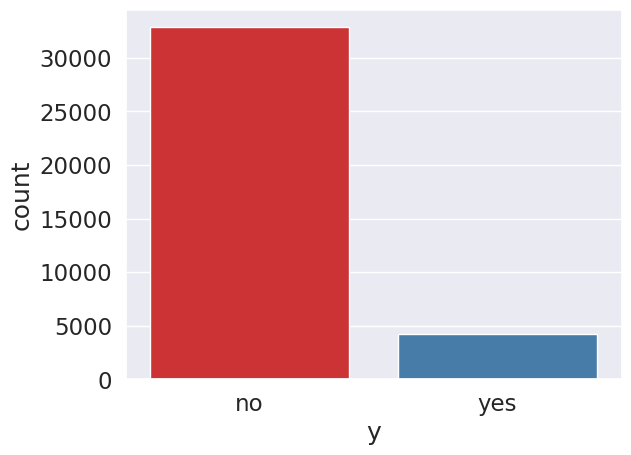

In [91]:
# create a count plot in seaborn to show the count of observations in each categorical bin using a bar 

sns.set(font_scale=1.5) #calling sns. setting the font
countplt=sns.countplot(x='y', data=campaign, palette ='Set1') # countplot for # catplot for categorical 
plt.show()


I think we may want to normalize the information 

In [92]:
# check for duplicates in our data 

campaign.duplicated().sum()

1487

Our data shows there are 1487 duplicates 

Do we want to drop them?
If so # Removing Duplicate Values
df = df.drop_duplicates()

In [93]:
yes = campaign[ campaign['y'] == 'yes']
yes['day_of_week'].value_counts()

day_of_week
thu    958
wed    865
tue    857
fri    767
mon    761
Name: count, dtype: int64

In [94]:
campaign.replace({'no':0,'yes':1},inplace=True)

In [95]:
from typing_extensions import dataclass_transform
'''import altair as alt

day = campaign.groupby(["day_of_week","y"])["day_of_week"].count()
day.head(15)

alt.Chart(day).mark_bar().transform_calculate().encode(
    alt.X('y:N', title='Survived', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    alt.Y('', title='Total Survivors'),
    column=alt.Column('day_of_week:N', title=None)
).properties(
    title='How Did Passenger Gender Affect Survival',
    width=100
)'''

'import altair as alt\n\nday = campaign.groupby(["day_of_week","y"])["day_of_week"].count()\nday.head(15)\n\nalt.Chart(day).mark_bar().transform_calculate().encode(\n    alt.X(\'y:N\', title=\'Survived\', axis=alt.Axis(labelFontSize=14, labelAngle=0)),\n    alt.Y(\'\', title=\'Total Survivors\'),\n    column=alt.Column(\'day_of_week:N\', title=None)\n).properties(\n    title=\'How Did Passenger Gender Affect Survival\',\n    width=100\n)'

In [96]:
check = campaign[["default", "housing", "loan"]]
check.apply(pd.Series.value_counts)
campaign = campaign.replace("unknown", np.nan)
#(campaign==np.nan).sum()
campaign.isna().sum()

age                  0
job                294
marital             69
education         1535
default           7725
housing            894
loan               894
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [97]:
# both default and poutcome have so little useable data in comparison to missing data or such a poor balance of values that I don't think they are worth using in training.
campaign = campaign.drop(["default", "poutcome"], axis=1)
campaign["housing"] = campaign["housing"].astype(float)
campaign["loan"] = campaign["loan"].astype(float)
campaign.dtypes

age                 int64
job                object
marital            object
education          object
housing           float64
loan              float64
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int64
dtype: object

In [98]:

campaign["education"]=campaign["education"].replace(["illiterate","basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"],[1,2,3,4,5,6,7])
campaign["education"].value_counts()
campaign = pd.get_dummies(campaign,prefix=["job"],columns=["job"])
campaign = pd.get_dummies(campaign,prefix=["marital"],columns=["marital"])
campaign = pd.get_dummies(campaign,prefix=["contact"],columns=["contact"])
#campaign["job"] = campaign["job"].replace(["unemployed","student","services","housemaid","blue-collar","technician","admin.","management","self-employed","entrepreneur","retired"],[0,1,2,3,4,5,6,7,8,9,10])
#campaign["job"].value_counts()


In [99]:
campaign['day_of_week'] = campaign['day_of_week'].replace(["mon","tue","wed","thu","fri"],[1,2,3,4,5]) 
campaign['month'] = campaign['month'].replace(["jan","feb","mar","apr", "may","jun", "jul", "aug", "sep", "oct", "nov", "dec"],[1,2,3,4,5,6,7,8,9,10,11,12]) 
print(campaign['day_of_week'].value_counts())
print(campaign['month'].value_counts())


day_of_week
4    7742
1    7657
3    7347
2    7287
5    7036
Name: count, dtype: int64
month
5     12370
7      6445
8      5555
6      4817
11     3698
4      2369
10      653
9       508
3       496
12      158
Name: count, dtype: int64


In [100]:
campaign.dtypes

age                    int64
education            float64
housing              float64
loan                 float64
month                  int64
day_of_week            int64
campaign               int64
pdays                  int64
previous               int64
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
euribor3m            float64
nr.employed          float64
y                      int64
job_admin.              bool
job_blue-collar         bool
job_entrepreneur        bool
job_housemaid           bool
job_management          bool
job_retired             bool
job_self-employed       bool
job_services            bool
job_student             bool
job_technician          bool
job_unemployed          bool
marital_divorced        bool
marital_married         bool
marital_single          bool
contact_cellular        bool
contact_telephone       bool
dtype: object

In [101]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(campaign[['loan','housing']])
campaign[['loan','housing']] = imp_mean.transform(campaign[['loan','housing']])
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(campaign[["education"]])
campaign[["education"]] = imp_mode.transform(campaign[["education"]])
campaign.isna().sum()

age                  0
education            0
housing              0
loan                 0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
job_admin.           0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
job_unemployed       0
marital_divorced     0
marital_married      0
marital_single       0
contact_cellular     0
contact_telephone    0
dtype: int64

In [102]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Encode our features and target as needed
features = ["age",
"education",
"housing",
"loan",
"month",
"day_of_week",
"campaign",
"pdays",
"emp.var.rate",
"cons.price.idx",
"cons.conf.idx",
"euribor3m",
"nr.employed",
"job_admin.",
"job_blue-collar",
"job_entrepreneur",
"job_housemaid",
"job_management",
"job_retired",
"job_self-employed",
"job_services",
"job_student",
"job_technician",
"job_unemployed",
"marital_divorced",
"marital_married",
"marital_single",
"contact_cellular",
"contact_telephone"]
X = pd.get_dummies(campaign[features], drop_first=True)
y = campaign['y']

# Split our data into training and test data, with 30% reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Build the decision tree
clf = DecisionTreeClassifier()

# Train it
clf.fit(X_train, y_train)

# Test it 
clf.score(X_test, y_test)

0.83985253124719

In [108]:
import pickle
s = pickle.dumps(clf)
clf2 = pickle.loads(s)

In [109]:
campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank_holdout_test.csv')
clf2 = pickle.loads(s)

campaign.replace({'no':0,'yes':1},inplace=True)

campaign = campaign.replace("unknown", np.nan)

campaign = campaign.drop(["default", "poutcome"], axis=1)
campaign["housing"] = campaign["housing"].astype(float)
campaign["loan"] = campaign["loan"].astype(float)

campaign["education"]=campaign["education"].replace(["illiterate","basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"],[1,2,3,4,5,6,7])
campaign["education"].value_counts()
campaign = pd.get_dummies(campaign,prefix=["job"],columns=["job"])
campaign = pd.get_dummies(campaign,prefix=["marital"],columns=["marital"])
campaign = pd.get_dummies(campaign,prefix=["contact"],columns=["contact"])

campaign['day_of_week'] = campaign['day_of_week'].replace(["mon","tue","wed","thu","fri"],[1,2,3,4,5]) 
campaign['month'] = campaign['month'].replace(["jan","feb","mar","apr", "may","jun", "jul", "aug", "sep", "oct", "nov", "dec"],[1,2,3,4,5,6,7,8,9,10,11,12]) 

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(campaign[['loan','housing']])
campaign[['loan','housing']] = imp_mean.transform(campaign[['loan','housing']])
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(campaign[["education"]])
campaign[["education"]] = imp_mode.transform(campaign[["education"]])


from pathlib import Path  
filepath = Path('out.csv')  
filepath.parent.mkdir(exist_ok=True)

predict = clf2.predict(campaign[features])
df = pd.DataFrame(predict, columns=["predictions"])

df.to_csv(filepath, index=False)

Does it make sense to call students at all?

In [110]:
# Does it make sense to call students at all?
import pandas as pd

campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')

yes = campaign[ campaign['y'] == 'yes']
yes['job'].value_counts()

job
admin.           1234
technician        659
blue-collar       568
retired           387
management        303
services          293
student           249
self-employed     137
unemployed        134
entrepreneur      113
housemaid          96
unknown            35
Name: count, dtype: int64

In [112]:
import altair as alt

alt.Chart(yes).mark_bar(
    
).encode(
    x=alt.X('job:N', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    y=alt.Y('count()', title='Number of People'),
).properties(
    title="The Job of the Client Aubscribed a Term Deposit",
    width=2000
)

ModuleNotFoundError: No module named 'altair'

In [113]:
# customers most likely to subscribe to a term deposit?
import pandas as pd

campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')

yes2 = campaign[ campaign['y'] == 'yes']

yes2.value_counts()

age  job         marital  education          default  housing  loan  contact   month  day_of_week  campaign  pdays  previous  poutcome     emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
30   admin.      single   university.degree  no       no       no    cellular  apr    thu          1         999    0         nonexistent  -1.8          93.075          -47.1          1.365      5099.1       yes    3
32   admin.      married  university.degree  no       yes      yes   cellular  jun    tue          1         999    0         nonexistent  -2.9          92.963          -40.8          1.262      5076.2       yes    2
26   unemployed  single   university.degree  no       yes      no    cellular  apr    tue          1         999    0         nonexistent  -1.8          93.075          -47.1          1.423      5099.1       yes    2
42   services    married  high.school        no       yes      no    cellular  apr    thu          1         999    0         nonexistent

In [114]:
yes2['age'].value_counts()

age
33    191
31    191
30    190
29    173
34    168
     ... 
92      3
17      2
98      2
89      2
87      1
Name: count, Length: 75, dtype: int64

In [115]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(yes2).mark_bar(
    
).encode(
    x=alt.X('age:N', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    y=alt.Y('count()', title='Number of People'),
).properties(
    title="The age of the Client Aubscribed a Term Deposit",
    width=2000
)

ModuleNotFoundError: No module named 'altair'

In [116]:
yes2['marital'].value_counts()

marital
married     2295
single      1465
divorced     439
unknown        9
Name: count, dtype: int64

In [117]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(yes2).mark_bar(
    
).encode(
    x=alt.X('marital:N', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    y=alt.Y('count()', title='Number of People'),
).properties(
    title="The Marrige status of the Client Aubscribed a Term Deposit",
    width=600
)

ModuleNotFoundError: No module named 'altair'

In [118]:
yes3 = campaign[ campaign['y'] == 'yes']
yes3 = campaign[ campaign['marital'] == 'married']
yes3['education'].value_counts()

education
university.degree      5762
high.school            4639
basic.9y               3736
basic.4y               2893
professional.course    2866
basic.6y               1609
unknown                 937
illiterate               14
Name: count, dtype: int64

In [119]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(yes3).mark_bar(
    
).encode(
    x=alt.X('education:N', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    y=alt.Y('count()', title='Number of People'),
).properties(
    title="The education status of the Client Aubscribed a Term Deposit",
    width=2000
)

ModuleNotFoundError: No module named 'altair'

In [120]:
yes3 = campaign[ campaign['education'] == 'university.degree']
yes3['default'].value_counts()

default
no         9655
unknown    1294
Name: count, dtype: int64

In [121]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(yes3).mark_bar(
    
).encode(
    x=alt.X('default:N', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    y=alt.Y('count()', title='Number of People'),
).properties(
    title="The default credit status of the Client Aubscribed a Term Deposit",
    width=2000
)

ModuleNotFoundError: No module named 'altair'

In [122]:
yes3 = campaign[ campaign['default'] == 'no']
yes3['housing'].value_counts()

housing
yes        15530
no         13124
unknown      687
Name: count, dtype: int64

In [123]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(yes3).mark_bar(
    
).encode(
    x=alt.X('housing:N', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    y=alt.Y('count()', title='Number of People'),
).properties(
    title="The having house loan status of the Client Aubscribed a Term Deposit",
    width=2000
)

ModuleNotFoundError: No module named 'altair'

#customers that are married, with a univercity degree, without default credit and having a house loan are more likely to subscribe to a term deposit

In [124]:
#Should we only call single people on Saturdays?
import pandas as pd

campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')

yes4 = campaign[ campaign['y'] == 'yes']
yes4 = campaign[ campaign['marital'] == 'single']

yes4['day_of_week'].value_counts()

day_of_week
thu    2291
wed    2114
mon    2070
tue    1979
fri    1956
Name: count, dtype: int64

In [125]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(yes4).mark_bar(
    
).encode(
    x=alt.X('day_of_week:N', axis=alt.Axis(labelFontSize=14, labelAngle=0)),
    y=alt.Y('count()', title='Number of People'),
).properties(
    title="Day os the week that a single Aubscribed a Term Deposit",
    width=2000
)

ModuleNotFoundError: No module named 'altair'

In [ ]:
#No single person Aubscribed a Term Deposit on Saturday